In [158]:
# Prerequisites for data collection
import os
import json
import pandas as pd
import numpy as np

# Prerequisite for BoDeGHa
import prerequisites as pq

#Prerequisite for displaying image in notebook
from IPython import display

## Data Collection

### 1. Install Perceval

In [ ]:
!pip install virtualenv
!virtualenv venv
!source venv/bin/activate
!pip install git+https://github.com/chaoss/grimoirelab-perceval

In [165]:
def query(PERCEVAL_LOCATION, owner, repo, TOKEN):
    """
    args:
    PERCEVAL_LOCATION: Perceval tool's location
    owner: repository owner
    repo: repository name
    TOKEN: GitHub API token for querying
    
    return: queried data in the form of json file
    
    Description: Connect to Perceval for querying the data corresponding to the required repository
    """
    
    query = 'perceval github {0} {1} --from-date 2021-12-01 --json-line --sleep-for-rate -t {2}'.format(owner, repo, TOKEN)
    COMMAND_STRING = PERCEVAL_LOCATION + ' && ' + query
    command_output = os.popen(COMMAND_STRING)
    command_result = command_output.read()
    return(command_result)

In [166]:
def fetch_and_save_data(PERCEVAL_LOCATION, REPOSITORY, TOKEN, FILE_SAVE_LOCATION):
    """
    args:
    PERCEVAL_LOCATION: Perceval tool's location (for passing it to query function)
    REPOSITORY: Full repository description in the form of owner/repo
    TOKEN: GitHub API token (for passing it to query function)
    FILE_SAVE_LOCATION: Location to save the perocessed data
    
    Descriotion: Pass the repository information to query function, receive the json file, extract the required fields for BoDeGHa's 
    ML part and save it as .csv file
    """
    
    for repository in pq.tqdm(REPOSITORY):
        owner = repository.split(r'/')[0]
        repo = repository.split(r'/')[1]
        raw_data = query(PERCEVAL_LOCATION, owner, repo, TOKEN)
        
        dict_list = [d.strip() for d in raw_data.splitlines()]
        json_format = [json.loads(i) for i in dict_list]
        
        formated_data = pd.DataFrame(columns=['author', 'body', 'number', 'created_at', 'empty']) 
        
        for line in json_format:
            try:
                for comment in range(len(line['data']['comments_data'])):
                    empty = 0
                    if len(line['data']['comments_data'][comment]['body']) < 2:
                        empty = 1
                    formated_data = formated_data.append({'author': line['data']['comments_data'][comment]['user_data']['login'],
                                                    'body': line['data']['comments_data'][comment]['body'],
                                                    'number': line['data']['number'],
                                                    'created_at': line['data']['comments_data'][comment]['created_at'],
                                                    'empty': empty
                                                   }, ignore_index=True)
            except:
                print('empty')
        file_name = FILE_SAVE_LOCATION + '{0}_{1}.json'.format(owner, repo)
        formated_data.to_csv(FILE_SAVE_LOCATION + '{0}_{1}.csv'.format(owner, repo))

In [168]:
PERCEVAL_LOCATION = 'source venv/bin/activate'
REPOSITORY = ['tokio-rs/tokio', 'SergioBenitez/Rocket', 'servo/servo', 'diem/diem', 'rust-lang/rust']
TOKEN = #provide GitHub API token here
FILE_SAVE_LOCATION = r'Data/'

fetch_and_save_data(PERCEVAL_LOCATION, REPOSITORY, TOKEN, FILE_SAVE_LOCATION)

100%|██████████| 1/1 [02:36<00:00, 156.57s/it]


## BODeGHa bot classification tool (only ML part)

### 1. Load the model 

In [7]:
def get_model():
    """
    Get BoDeGHa's trained machine learning model
    """
    
    path = 'model.json'
    filename = pq.pkg_resources.resource_filename(__name__, path)
    with open(filename, 'rb') as file:
        model = pq.pickle.load(file)
    return model

In [122]:
"""
Enter the file name that has the processed data for BoDeGHa's trained ML part to work on
"""
input_file_name = r'Data/rust-lang_rust.csv'#SergioBenitez_Rocket.csv'
output_file_name = r'Prediction/rust-lang_rust.csv'
comments = pd.read_csv(input_file_name, index_col = 0)

In [123]:
"""
User fixed constants for executing BoDeGHa
"""

MIN_COMMENTS = 10
MAX_COMMENTS = 100
EXCLUDE = [] # exclude these accounts
ACCOUNTS = []#['JoshLind', 'stale[bot]', 'libra-action', 'dimroc'] # consider only these accounts

In [124]:
"""
To get the top 100 comments for each author in the repository
"""

df = (
    comments
    [comments['author'].isin(
    comments
    .groupby('author', as_index = False)
    .count()[lambda x: x['body'] >= MIN_COMMENTS]['author'].values
    )]
    .sort_values('created_at', ascending = False)
    .groupby('author').head(MAX_COMMENTS)
)

In [125]:
"""
To either EXCLUDE or INCLUDE few accounts and to check if there is at least one account to execute the machine learning model
"""

if len(EXCLUDE) > 0:
    df = df[~df['author'].isin(EXCLUDE)]

if len(ACCOUNTS) > 0:
    df = df[lambda x: x['author'].isin(ACCOUNTS)]

if(len(df) < 1):
    print("At least 10 comments are required for each account to predict the type of the account")

In [126]:
"""
To calculate the jaccard and levenshtein for any pair of comments made by the author 
"""

inputs = []
for author, group in df.groupby('author'):
    inputs.append(
        (
            author,
            group.copy(),
            MAX_COMMENTS,
            {'func': pq.average_jac_lev, 'source': 'body', 'eps': 0.5}
        )
    )

In [127]:
"""
Store the features used for classification along with other required fields in a data frame
"""

data = []
for item in pq.tqdm(inputs,
                desc='Computing features',
                smoothing=.1,
                bar_format='{desc}: {percentage:3.0f}%|{bar}'):
    data.append(pq.task(item))
result = pd.DataFrame(
        data=data, columns=['account', 'comments', 'empty comments', 'patterns', 'dispersion'])

Computing features: 100%|██████████


In [133]:
"""
Predict the type of the account
"""

model = pq.run_function_in_thread(get_model, 5)
result = (
        result
        .assign(
            prediction=lambda x: np.where(model.predict(
                x[['comments', 'empty comments', 'patterns', 'dispersion']]) == 1, 'Bot', 'Human')
        )
    )
del model
result = result.sort_values(['prediction', 'account']).assign(patterns= lambda x: x['patterns'].astype('Int64'))

In [ ]:
"""
Formatting and ordering
"""
result = (
            result
            .set_index('account')
            [['comments', 'empty comments', 'patterns', 'dispersion', 'prediction']]
        )

In [130]:
result.to_csv(output_file_name)

## Visualization Using Kibana

### A. Prepare the files for Visualization

In [149]:
"""
Enter the set of repositories for which visualization is required
"""
FILE_LOCATION = r'Prediction'
predited_files = ['diem_diem', 'paritytech_substrate', 'rust-lang_rust', 
                  'tokio-rs_tokio', 'servo_servo']

In [156]:
"""
Combining all the required data into a single file as Kibana accepts only one csv at a time
"""
all_data = pd.DataFrame()
for file in predited_files:
    temp_df = pd.read_csv(FILE_LOCATION + '/' + file + '.csv')
    temp_df['repository'] = file
    all_data = all_data.append(temp_df, ignore_index = 0)
all_data.to_csv('Prediction/all_data.csv')

### B. The following process is obtained from https://www.elastic.co/guide/en/kibana/current/docker.html

### Prerequisite: Docker (the desktop version can be downloaded from https://docs.docker.com/get-docker/)

#### 1. Open Terminal
#### 2. Execute "docker network ls"
##### &emsp; &ensp; if elastic is not in NAME then execute 2.1 else execute 3
##### &emsp; &ensp; 2.1 Execute "docker network create elastic"
#### 3. Execute the following in the terminal to start Elasticsearch container - es-container-name is user specific (e.g., es01)
#### &emsp; "docker run --name < es-container-name > --net elastic -p 127.0.0.1:9200:9200 -p 127.0.0.1:9300:9300 -e "discovery.type=single-node" docker.elastic.co/elasticsearch/elasticsearch:7.16.3"
#### 4. Open another terminal window and execute the following to to start kibana and connect it to your Elasticsearch container - kib-container-name is user specific (e.g., kib01)
#### &emsp; "docker run --name < kib-container-name > --net elastic -p 127.0.0.1:5601:5601 -e "ELASTICSEARCH_HOSTS=http://< es-container-name >:9200" docker.elastic.co/kibana/kibana:7.16.3"
#### &emsp; Note: Both the container names should be different
#### 5. The port number given in step 4 is "5601". So open the browser and type " http://localhost:5601 " (Feel free to modify the port number in step 4 and make sure the same port number is present in the link in this step)
#### 6. This opens the Kibana dashboard
#### 7. Navigate to Dashboard, upload the "all_data.csv" file generated through this script and proceed for visualization
### A sample visualization obtained from Kibana for visualizing the number and the type of accounts is shown below

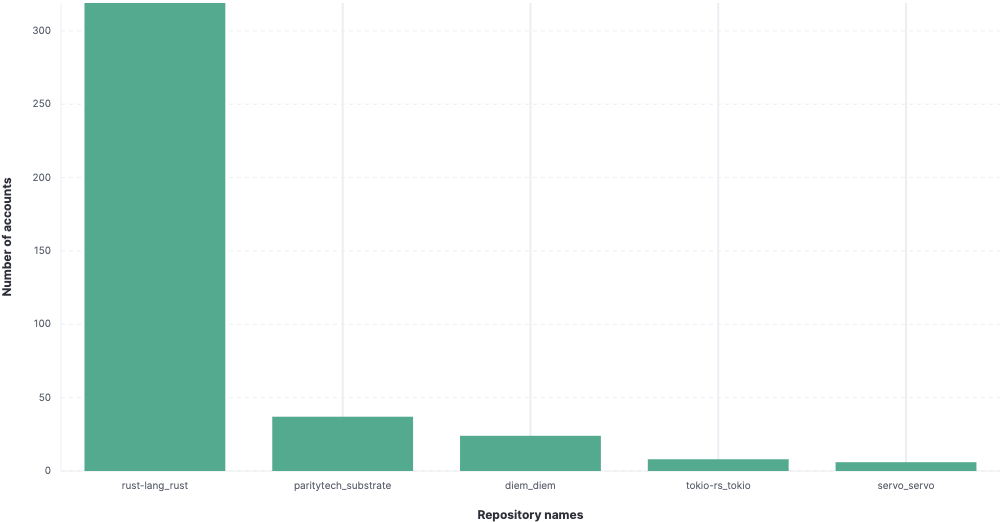

In [163]:
display.Image("AllAccounts.png")

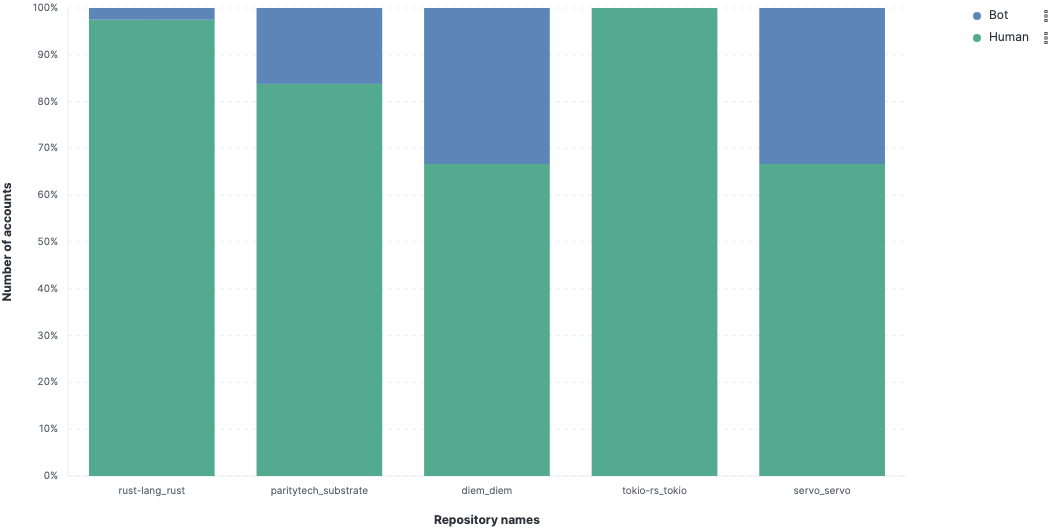

In [164]:
display.Image("WithBots.png")